In [2]:
import numpy as np
from plind.contour_dict import realcontour_1D, realcontour_nd
from plind.integrate import conintegrate
from plind import plmodel
from plind.contour import contour
import matplotlib.pyplot as plt
from math import factorial as fact
import itertools
from time import time

In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
def cantor_pairing(a, b):
    return (0.5*(a+b)*(a+b+1)+b).astype(int)

def refine(simplices, points, edges, delta, ndim):
    # construct edges from simplices and compute lengths
    #edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])
    
    if ndim==1:
        points = points.flatten()
        
    diff = points[edges[:,:,0]] - points[edges[:,:,1]]
    if ndim==1:
        lengths = np.abs(np.sqrt(diff**2))
    else:
        lengths = np.abs(np.sqrt(np.sum([diff[:,:,i]**2 for i in np.arange(diff.shape[2])], axis=0)))

    # find edges that exceed delta
    where = np.where(lengths>delta)
    if len(where[0])>0:
        all_bad_edges = edges[where]
        all_edge_key = cantor_pairing(all_bad_edges[:,0], all_bad_edges[:,1]) # unique indetifier for each edge

        # make it so there is only one edge per simplex, and remove secondary edges as flagged edges
        bad_simp_ind, prim_edge_ind = np.unique(where[0], return_index=True)
        dupl_edge_key = np.delete(all_edge_key, prim_edge_ind)
        dupl_edge_ind = np.where(np.in1d(all_edge_key, dupl_edge_key))[0]

        bad_simp_ind = np.delete(where[0], dupl_edge_ind)
        bad_simps = simplices[bad_simp_ind]
        bad_edges = np.delete(all_bad_edges, dupl_edge_ind, axis=0)
        edge_key = np.delete(all_edge_key, dupl_edge_ind)

        # create new points to add to simplices and also determine the index of these new points once added to self.points
        uni_edge_key, unique_inds = np.unique(edge_key, return_index=True) # identify unique edges (as edges may be shared by simplices)
        uni_bad_edges = bad_edges[unique_inds]

        new_pnts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
        #newpnts_inds = np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key]) + len(points)
        newpnts_inds = np.where(uni_edge_key==edge_key[:,None])[1] + len(points)

        A = np.hstack([newpnts_inds[:, None], bad_simps[np.where(bad_simps != bad_edges[:,0][:,None])].reshape(bad_simps.shape[0], bad_simps.shape[1]-1)])
        B = np.hstack([newpnts_inds[:, None], bad_simps[np.where(bad_simps != bad_edges[:,1][:,None])].reshape(bad_simps.shape[0], bad_simps.shape[1]-1)])
        #A = np.hstack([newpnts_inds[:, None], np.array([simp[np.where(simp != e0)] for simp, e0 in zip(bad_simps, bad_edges[:,0])])])
        #B = np.hstack([newpnts_inds[:, None], np.array([simp[np.where(simp != e1)] for simp, e1 in zip(bad_simps, bad_edges[:,1])])])
        new_simps = np.concatenate([A,B])
        new_edges = np.array([list(itertools.combinations(simp, 2)) for simp in new_simps])

        new_simps = np.concatenate([np.delete(simplices, bad_simp_ind, axis=0), new_simps])
        new_pnts = np.concatenate([points, new_pnts])
        new_edges = np.concatenate([np.delete(edges, bad_simp_ind, axis=0), new_edges])
        
        if ndim==1:
            new_pnts = new_pnts[:, None]
        return new_simps, new_pnts, new_edges
    else:
        return simplices, points, edges



In [49]:
# 2D check
delta = 0.72
points = np.array([[0., 0.],
           [0., 1.],
           [1., 1.],
           [0.6,0.],
           [0.7, 0.7],
           [-0.001, 0.5]])
simplices = np.array([[0,1,4], [1,2,4],[2,4,3],[0,4,3],[0,1,5]])
edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])

new_simps, new_pnts, new_edges = refine(simplices, points, edges, delta, 2)
print(new_simps, '\n', new_pnts)

[[0 4 3]
 [6 1 4]
 [7 2 4]
 [8 4 3]
 [6 1 5]
 [6 0 4]
 [7 1 4]
 [8 2 4]
 [6 0 5]] 
 [[ 0.     0.   ]
 [ 0.     1.   ]
 [ 1.     1.   ]
 [ 0.6    0.   ]
 [ 0.7    0.7  ]
 [-0.001  0.5  ]
 [ 0.     0.5  ]
 [ 0.5    1.   ]
 [ 0.8    0.5  ]]


In [50]:
ndim=2
if ndim==1:
    points = points.flatten()
        
diff = points[edges[:,:,0]] - points[edges[:,:,1]]
if ndim==1:
    lengths = np.abs(np.sqrt(diff**2))
else:
    lengths = np.abs(np.sqrt(np.sum([diff[:,:,i]**2 for i in np.arange(diff.shape[2])], axis=0)))

# find edges that exceed delta
where = np.where(lengths>delta)
if len(where[0])>0:
    all_bad_edges = edges[where]
    all_edge_key = cantor_pairing(all_bad_edges[:,0], all_bad_edges[:,1]) # unique indetifier for each edge

    # make it so there is only one edge per simplex, and remove secondary edges as flagged edges
    bad_simp_ind, prim_edge_ind = np.unique(where[0], return_index=True)
    dupl_edge_key = np.delete(all_edge_key, prim_edge_ind)
    dupl_edge_ind = np.where(np.in1d(all_edge_key, dupl_edge_key))[0]

    bad_simp_ind = np.delete(where[0], dupl_edge_ind)
    bad_simps = simplices[bad_simp_ind]
    bad_edges = np.delete(all_bad_edges, dupl_edge_ind, axis=0)
    edge_key = np.delete(all_edge_key, dupl_edge_ind)

    # create new points to add to simplices and also determine the index of these new points once added to self.points
    uni_edge_key, unique_inds = np.unique(edge_key, return_index=True) # identify unique edges (as edges may be shared by simplices)
    uni_bad_edges = bad_edges[unique_inds]

    new_pnts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
    #newpnts_inds = np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key]) + len(points)
    newpts_ints = np.where(uni_edge_key==edge_key[:,None])[1] + len(points)

    A = np.hstack([newpnts_inds[:, None], bad_simps[np.where(bad_simps != bad_edges[:,0][:,None])].reshape(bad_simps.shape[0], bad_simps.shape[1]-1)])
    B = np.hstack([newpnts_inds[:, None], bad_simps[np.where(bad_simps != bad_edges[:,1][:,None])].reshape(bad_simps.shape[0], bad_simps.shape[1]-1)])

In [51]:
np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key])

array([0, 1, 2, 0])

In [52]:
edge_key[:,None]

array([[ 2],
       [ 8],
       [18],
       [ 2]])

In [53]:
uni_edge_key

array([ 2,  8, 18])

In [54]:
np.where(uni_edge_key==edge_key[:,None])[1]

array([0, 1, 2, 0])

In [55]:
t0 = 0
t1 = 0
for i in np.arange(1000):
    t2 = time()
    np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key])
    t0 += time()-t2
    t3 = time()
    np.where(uni_edge_key==edge_key[:,None])[1]
    t1 += time()-t3
print(t1/1000, t0/1000)
    

5.773782730102539e-06 1.746988296508789e-05


In [56]:
# 1D check
delta = 0.72
points = np.array([[0.],[1.+1j],[2+2j],[3+3j],[3.1+3.1j]]).flatten()
simplices = np.array([[0,1],[1,2],[2,3],[3,4]])
edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])

new_simps, new_pnts, new_edges = refine(simplices, points, edges, delta, 1)
print(new_simps, '\n', new_pnts)

[[3 4]
 [5 1]
 [6 2]
 [7 3]
 [5 0]
 [6 1]
 [7 2]] 
 [[0. +0.j ]
 [1. +1.j ]
 [2. +2.j ]
 [3. +3.j ]
 [3.1+3.1j]
 [0.5+0.5j]
 [1.5+1.5j]
 [2.5+2.5j]]


In [57]:
# 3D test
delta = 1.
points = np.array([[0., 0., 0.],
                  [1., 0., 0.],
                  [0., 1., 0.],
                  [0., 0., 1.],
                  [1., 1., 1.]])
simplices = np.array([[0,1,2,3],[1,2,3,4]])
edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])

new_simps, new_pnts, new_edges = refine(simplices, points, edges, delta, 3)
print(new_simps, '\n', new_pnts)

[[5 0 2 3]
 [5 2 3 4]
 [5 0 1 3]
 [5 1 3 4]] 
 [[0.  0.  0. ]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [1.  1.  1. ]
 [0.5 0.5 0. ]]


In [121]:
ctr = contour(points, simplices)
print(ctr.simplices)
print(ctr.points)

[[0 1 4]
 [1 2 4]
 [2 4 3]
 [0 4 3]
 [0 1 5]]
[[ 0.     0.   ]
 [ 0.     1.   ]
 [ 1.     1.   ]
 [ 0.6    0.   ]
 [ 0.7    0.7  ]
 [-0.001  0.5  ]]


In [122]:
ctr.remove_points([0])
print(ctr.simplices)
print(ctr.points)
print(ctr.edges)

[[0 1 3]
 [1 3 2]]
[[ 0.     1.   ]
 [ 1.     1.   ]
 [ 0.6    0.   ]
 [ 0.7    0.7  ]
 [-0.001  0.5  ]]
[[[0 1]
  [0 3]
  [1 3]]

 [[1 3]
  [1 2]
  [3 2]]]


In [99]:
# big test
def time_algorithms(N):
    Nit = 3
    contour = realcontour_nd(N, (-0.5,0.5,-0.5,0.5))
    num_simp = len(contour.simplices)
    t0 = time()
    for i in np.arange(Nit):
        new_simps, new_pnts, new_edges = refine(contour.simplices, contour.points, 0.00001, contour.ndim)
    t1 = time()

    refine_time = 0
    for i in np.arange(Nit):
        contour = realcontour_nd(N, (-0.5,0.5,-0.5,0.5))
        t2 = time()
        contour.refine_edges(0.00001)
        t3 = time()
        refine_time += t3-t2
    return num_simp, (t1-t0)/Nit, refine_time/Nit

In [10]:
Ns = [2, 3, 4, 5, 10, 20, 40, 60, 100]
times = []
for N in Ns:
    times.append(time_algorithms(N))
times = np.array(times)

edge reconstruction:  1.9073486328125e-05 , refinement:  0.0004177093505859375
edge reconstruction:  1.9073486328125e-05 , refinement:  0.0003600120544433594
edge reconstruction:  2.1696090698242188e-05 , refinement:  0.0005707740783691406
edge reconstruction:  4.076957702636719e-05 , refinement:  0.0006117820739746094
edge reconstruction:  4.1961669921875e-05 , refinement:  0.0010309219360351562
edge reconstruction:  4.601478576660156e-05 , refinement:  0.0009579658508300781
edge reconstruction:  0.000141143798828125 , refinement:  0.000982046127319336
edge reconstruction:  0.00015997886657714844 , refinement:  0.0013346672058105469
edge reconstruction:  8.130073547363281e-05 , refinement:  0.0005970001220703125
edge reconstruction:  0.0002789497375488281 , refinement:  0.0009059906005859375
edge reconstruction:  0.0001201629638671875 , refinement:  0.0007839202880859375
edge reconstruction:  0.00012421607971191406 , refinement:  0.0008077621459960938
edge reconstruction:  0.000566959

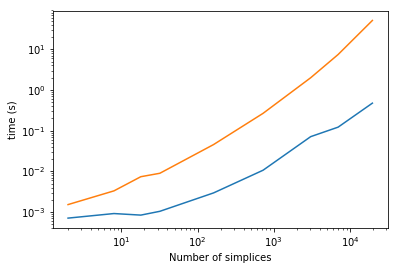

In [958]:
fig, ax = plt.subplots()
ax.plot(times[:,0], times[:,1], label='new')
ax.plot(times[:,0], times[:,2], label='old')
ax.set_xlabel('Number of simplices')
ax.set_ylabel('time (s)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# Attempt 1

In [609]:
def cantor_pairing(a, b):
    return (0.5*(a+b)*(a+b+1)+b).astype(int)

def refine(simplices, points, delta, ndim):
    # construct edges from simplices and compute lengths
    edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])
    diff = points[edges[:,:,0]] - points[edges[:,:,1]]
    if ndim==1:
        lengths = np.abs(np.sqrt(diff**2))
    else:
        lengths = np.abs(np.sqrt(np.sum([diff[:,:,i]**2 for i in np.arange(diff.shape[2])], axis=0)))
    
    # find edges that exceed delta
    where = np.where(lengths>delta)
    bad_simp_ind = np.unique(where[0])
    bad_edges = edges[where]

    # use cantor pairing function to assign unique identifier for an edge to identify duplicates
    edge_key = cantor_pairing(bad_edges[:,0], bad_edges[:,1])
    uni_edge_key, unique_inds = np.unique(edge_key, return_index=True)
    uni_bad_edges = bad_edges[unique_inds]
    
    # create new points to add to simplices and also determine the index of these new points once added to self.points
    uni_edgepts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
    centres = (np.sum(points[simplices[bad_simp_ind]], axis=1))/simplices.shape[1]
    new_pnts = np.concatenate([uni_edgepts, centres])
    edgepts_inds = np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key]) + len(points)
    centrepts_inds = np.arange(len(centres)) + len(points) + len(uni_edgepts)

    # generate new simplices 
    new_simplices = simplices 
    for i, simp in enumerate(simplices):
        cp = centrepts_inds[i]
        edpt = edgepts_inds[where[0]==i]
        bad_e = bad_edges[where[0]==i]

        orig_e = np.array(list(itertools.combinations(simp, 2)))
        good_e = orig_e[np.invert((orig_e[:,None] == bad_e).all(2).any(1))]

        not_centre_es = np.array([list(itertools.combinations(np.concatenate([bad_e[i], [ep]]), 2)) for i, ep in enumerate(edpt)])
        not_centre_es = not_centre_es.reshape(not_centre_es.shape[0]*not_centre_es.shape[1], 2)

        A = np.concatenate([not_centre_es, orig_e])
        not_centre_es = A[np.invert((A[:, None] == orig_e).all(2).any(1))]
        not_centre_es = np.concatenate([not_centre_es, good_e])

        cstack = np.array([[cp]]*len(not_centre_es))
        new_simps = np.hstack([not_centre_es, cstack])
        new_simplices = np.concatenate([new_simplices, new_simps])

    new_simplices = np.delete(new_simplices, bad_simp_ind, axis=0)
    new_points = np.concatenate([points, new_pnts])
    return new_simplices, new_points


In [606]:
# 2D test
delta = 2.5
points = np.array([[0., -1.],
           [0., 1.],
           [3., 0.],
           [2.,2.]])
simplices = np.array([[0,1,2], [1,2,3]])

new_simps, new_pnts = refine(simplices, points, delta, 2)

print(new_pnts)
print(new_simps)

[[ 0.         -1.        ]
 [ 0.          1.        ]
 [ 3.          0.        ]
 [ 2.          2.        ]
 [ 1.5        -0.5       ]
 [ 1.5         0.5       ]
 [ 1.          0.        ]
 [ 1.66666667  1.        ]]
[[0 4 6]
 [2 4 6]
 [1 5 6]
 [2 5 6]
 [0 1 6]
 [1 5 7]
 [2 5 7]
 [1 3 7]
 [2 3 7]]


In [612]:
# 1D test
delta = 1.
points = np.array([0., 1.+1j, 2.+2j, 3.+3j, 3.1+3.1j])
simplices = np.array([[0,1],[1,2],[2,3],[3,4]])
ndim = 1

#new_simps, new_pnts = refine(simplices, points, delta, 1)

#print(new_pnts)
#print(new_simps)

 # construct edges from simplices and compute lengths
edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])
diff = points[edges[:,:,0]] - points[edges[:,:,1]]
if ndim==1:
    lengths = np.abs(np.sqrt(diff**2))
else:
    lengths = np.abs(np.sqrt(np.sum([diff[:,:,i]**2 for i in np.arange(diff.shape[2])], axis=0)))

# find edges that exceed delta
where = np.where(lengths>delta)
bad_simp_ind = np.unique(where[0])
bad_edges = edges[where]

# use cantor pairing function to assign unique identifier for an edge to identify duplicates
edge_key = cantor_pairing(bad_edges[:,0], bad_edges[:,1])
uni_edge_key, unique_inds = np.unique(edge_key, return_index=True)
uni_bad_edges = bad_edges[unique_inds]

# create new points to add to simplices and also determine the index of these new points once added to self.points
uni_edgepts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
centres = (np.sum(points[simplices[bad_simp_ind]], axis=1))/simplices.shape[1]
new_pnts = np.concatenate([uni_edgepts, centres])
edgepts_inds = np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key]) + len(points)
centrepts_inds = np.arange(len(centres)) + len(points) + len(uni_edgepts)

# generate new simplices 
new_simplices = simplices 
for i, simp in enumerate(simplices):
    cp = centrepts_inds[i]
    edpt = edgepts_inds[where[0]==i]
    bad_e = bad_edges[where[0]==i]

    orig_e = np.array(list(itertools.combinations(simp, 2)))
    good_e = orig_e[np.invert((orig_e[:,None] == bad_e).all(2).any(1))]

    not_centre_es = np.array([list(itertools.combinations(np.concatenate([bad_e[i], [ep]]), 2)) for i, ep in enumerate(edpt)])
    not_centre_es = not_centre_es.reshape(not_centre_es.shape[0]*not_centre_es.shape[1], 2)

    A = np.concatenate([not_centre_es, orig_e])
    not_centre_es = A[np.invert((A[:, None] == orig_e).all(2).any(1))]
    not_centre_es = np.concatenate([not_centre_es, good_e])

    cstack = np.array([[cp]]*len(not_centre_es))
    new_simps = np.hstack([not_centre_es, cstack])
    new_simplices = np.concatenate([new_simplices, new_simps])

new_simplices = np.delete(new_simplices, bad_simp_ind, axis=0)
new_points = np.concatenate([points, new_pnts])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 3

In [619]:
orig_e

array([[0, 1]])

# developing

In [539]:
delta = 2
c = contour()
c.points = np.array([[0., -1.],
           [0., 1.],
           [3., 0.],
           [2.,2.]])
c.simplices = np.array([[0,1,2], [1,2,3]])
ndim = 2

In [540]:
max_edge_arg = np.argmax(ei_dot_ej.reshape(-1, ei_dot_ej.shape[-1]), axis=0)
print(max_edge_arg)

[2 1]


In [541]:
A = np.stack((max_edge_arg//(ndim+1), max_edge_arg%(ndim+1)), axis=1)[bad_simp_ind]
print(A)

[[0 2]
 [0 1]]


In [542]:
bad_edges = np.array([bad_simp[i][a] for i,a in enumerate(A)])
print(bad_edges)

[[0 2]
 [1 2]]


In [543]:
bad_simps = c.simplices[bad_simp_ind]

In [544]:
all(x in bad_simp[0] for x in bad_edges[0])

True

In [545]:
np.isin(c.simplices, bad_edges)

array([[ True,  True,  True],
       [ True,  True, False]])

In [546]:
bad_simp

array([[0, 1, 2],
       [1, 2, 3]])

In [547]:
np.array(list(itertools.product(c.simplices, c.simplices)))

array([[[0, 1, 2],
        [0, 1, 2]],

       [[0, 1, 2],
        [1, 2, 3]],

       [[1, 2, 3],
        [0, 1, 2]],

       [[1, 2, 3],
        [1, 2, 3]]])

In [548]:
np.subtract(c.simplices[:, None], -c.simplices[None, :])/2

array([[[0. , 1. , 2. ],
        [0.5, 1.5, 2.5]],

       [[0.5, 1.5, 2.5],
        [1. , 2. , 3. ]]])

In [549]:
c.simplices[None, :]

array([[[0, 1, 2],
        [1, 2, 3]]])

In [550]:
ei_dot_ej

array([[[ 0.,  0.],
        [ 4., 10.],
        [10.,  5.]],

       [[ 4., 10.],
        [ 0.,  0.],
        [10.,  5.]],

       [[10.,  5.],
        [10.,  5.],
        [ 0.,  0.]]])

In [551]:
np.where((ei_dot_ej>5).flatten())

(array([ 3,  4,  7, 10, 12, 14]),)

In [552]:
np.sum(ei_dot_ej>delta**2, axis=1)

array([[1, 2],
       [1, 2],
       [2, 2]])

In [553]:
np.sum(np.sum(ei_dot_ej>delta**2, axis=1), axis=0)

array([4, 6])

In [554]:
bad_simp_ind = np.where(np.sum(np.sum(ei_dot_ej>delta**2, axis=1), axis=0))[0]

In [555]:
bad_simp_ind

array([0, 1])

In [556]:
edges = np.array([list(itertools.combinations(simp, 2)) for simp in c.simplices])
print(edges)

[[[0 1]
  [0 2]
  [1 2]]

 [[1 2]
  [1 3]
  [2 3]]]


In [565]:
diff = c.points[edges[:,:,0]]-c.points[edges[:,:,1]]
lengths = np.abs(np.sqrt(np.sum([diff[:,:,i]**2 for i in np.arange(diff.shape[2])], axis=0)))
print(diff)
print(lengths)

[[[ 0. -2.]
  [-3. -1.]
  [-3.  1.]]

 [[-3.  1.]
  [-2. -1.]
  [ 1. -2.]]]
[[2.         3.16227766 3.16227766]
 [3.16227766 2.23606798 2.23606798]]


In [472]:
where = np.where(lengths>2.5)
bad_simp_ind = np.unique(where[0])
print(where)
print(bad_simp_ind)

(array([0, 0, 1]), array([1, 2, 0]))
[0 1]


In [473]:
bad_edges = edges[where]
print(bad_edges)

[[0 2]
 [1 2]
 [1 2]]


In [474]:
def cantor_pairing(a, b):
   return (0.5*(a+b)*(a+b+1)+b).astype(int)

edge_key = cantor_pairing(bad_edges[:,0], bad_edges[:,1])
print(edge_key)

[5 8 8]


In [475]:
uni_edge_key, unique_inds = np.unique(edge_key, return_index=True)
uni_bad_edges = bad_edges[unique_inds]
print(unique_inds)
print(uni_bad_edges)

[0 1]
[[0 2]
 [1 2]]


In [476]:
uni_edgepts = (c.points[uni_bad_edges[:, 0]] + c.points[uni_bad_edges[:, 1]])/2
centres = (np.sum(c.points[c.simplices[bad_simp_ind]], axis=1))/c.simplices.shape[1]
new_pnts = np.concatenate([uni_edgepts, centres])
print(edgepts)
print(centres)

[[ 1.5 -0.5]
 [ 1.5  0.5]]
[[1.         0.        ]
 [1.66666667 1.        ]]


In [477]:
edgepts_inds = np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key]) + len(c.points)
centrepts_inds = np.arange(len(centres)) + len(c.points) + len(uni_edgepts)
print(edgepts_inds)
print(centrepts_inds)

[4 5 5]
[6 7]


In [478]:
print(where)
print(c.simplices)
print(edgepts_inds)
print(centrepts_inds)

(array([0, 0, 1]), array([1, 2, 0]))
[[0 1 2]
 [1 2 3]]
[4 5 5]
[6 7]


In [491]:
new_simplices = c.simplices
for i, simp in enumerate(c.simplices):
    cp = centrepts_inds[i]
    edpt = edgepts_inds[where[0]==i]
    bad_e = bad_edges[where[0]==i]

    orig_e = np.array(list(itertools.combinations(simp, 2)))
    good_e = orig_e[np.invert((orig_e[:,None] == bad_e).all(2).any(1))]

    not_centre_es = np.array([list(itertools.combinations(np.concatenate([bad_e[i], [ep]]), 2)) for i, ep in enumerate(edpt)])
    not_centre_es = not_centre_es.reshape(not_centre_es.shape[0]*not_centre_es.shape[1], 2)

    A = np.concatenate([not_centre_es, orig_e])
    not_centre_es = A[np.invert((A[:, None] == orig_e).all(2).any(1))]
    not_centre_es = np.concatenate([not_centre_es, good_e])

    cstack = np.array([[cp]]*len(not_centre_es))
    new_simps = np.hstack([not_centre_es, cstack])
    new_simplices = np.concatenate([new_simplices, new_simps])

new_simplices = np.delete(new_simplices, bad_simp_ind, axis=0)
new_points = np.concatenate([c.points, new_pnts])
print(new_simplices)
print(new_points)


[[0 4 6]
 [2 4 6]
 [1 5 6]
 [2 5 6]
 [0 1 6]
 [1 5 7]
 [2 5 7]
 [1 3 7]
 [2 3 7]]
[[ 0.         -1.        ]
 [ 0.          1.        ]
 [ 3.          0.        ]
 [ 2.          2.        ]
 [ 1.5        -0.5       ]
 [ 1.5         0.5       ]
 [ 1.          0.        ]
 [ 1.66666667  1.        ]]


array([[0, 4, 6],
       [2, 4, 6],
       [1, 5, 6],
       [2, 5, 6],
       [0, 1, 6],
       [1, 5, 7],
       [2, 5, 7],
       [1, 3, 7],
       [2, 3, 7]])

In [447]:
new_simplices

array([array([[0, 4, 6],
       [2, 4, 6],
       [1, 5, 6],
       [2, 5, 6],
       [0, 1, 6]]),
       array([[1, 5, 7],
       [2, 5, 7],
       [1, 3, 7],
       [2, 3, 7]])], dtype=object)

In [443]:
cp = centrepts_inds[0]
edpt = edgepts_inds[where[0]==0]
bad_e = bad_edges[where[0]==0]

orig_e = np.array(list(itertools.combinations(c.simplices[0], 2)))
good_e = orig_e[np.invert((orig_e[:,None] == bad_e).all(2).any(1))]

not_centre_es = np.array([list(itertools.combinations(np.concatenate([bad_e[i], [ep]]), 2)) for i, ep in enumerate(edpt)])
not_centre_es = not_centre_es.reshape(not_centre_es.shape[0]*not_centre_es.shape[1], 2)

A = np.concatenate([not_centre_es, orig_e])
not_centre_es = A[np.invert((A[:, None] == orig_e).all(2).any(1))]
not_centre_es = np.concatenate([not_centre_es, good_e])

cstack = np.array([[cp]]*len(not_centre_es))
new_simps = np.hstack([not_centre_es, cstack])

print(cp)
print(edpt)
print(bad_e)
print(orig_e)
print(good_e)
print(not_centre_es)
print(new_simps)


6
[4 5]
[[0 2]
 [1 2]]
[[0 1]
 [0 2]
 [1 2]]
[[0 1]]
[[0 4]
 [2 4]
 [1 5]
 [2 5]
 [0 1]]
[[0 4 6]
 [2 4 6]
 [1 5 6]
 [2 5 6]
 [0 1 6]]


In [438]:
np.hstack([not_centre_es, cstack])


array([[6, 4, 6],
       [6, 4, 6],
       [6, 5, 6],
       [6, 5, 6],
       [6, 1, 6]])

In [435]:
not_centre_es

array([[6, 4],
       [6, 4],
       [6, 5],
       [6, 5],
       [6, 1]])

In [409]:
not_centre_es

array([[[0, 2],
        [0, 4],
        [2, 4]],

       [[1, 2],
        [1, 5],
        [2, 5]]])

In [647]:
ndim = 3
simp = np.array([0,1,2,3])
bad_e = np.array([[0,1]])
edpt = np.array([4])
cp = 5

orig_face = np.array(list(itertools.combinations(simp, ndim)))
bad_face_loc = (np.sum(np.isin(orig_face, bad_e), axis=1) == 2)
bad_face = orig_face[bad_face_loc]
good_face = orig_face[np.invert(bad_face_loc)]

not_centre_faces = np.array([list(itertools.combinations(np.concatenate([bad_face[i], [ep]]), ndim)) for i, ep in enumerate(edpt)])
# not_centre_es = not_centre_es.reshape(not_centre_es.shape[0]*not_centre_es.shape[1], 2)

# A = np.concatenate([not_centre_es, orig_e])
# not_centre_es = A[np.invert((A[:, None] == orig_e).all(2).any(1))]
# not_centre_es = np.concatenate([not_centre_es, good_e])

# cstack = np.array([[cp]]*len(not_centre_es))
# new_simps = np.hstack([not_centre_es, cstack])
# new_simplices = np.concatenate([new_simplices, new_simps])

In [642]:
orig_face

array([[0, 1, 2],
       [0, 1, 3],
       [0, 2, 3],
       [1, 2, 3]])

In [643]:
good_face

array([[0, 2, 3],
       [1, 2, 3]])

In [644]:
bad_face

array([[0, 1, 2],
       [0, 1, 3]])

In [648]:
not_centre_faces

array([[[0, 1, 2],
        [0, 1, 4],
        [0, 2, 4],
        [1, 2, 4]]])

# Another attempt

In [884]:
delta = 0.72
points = np.array([[0., 0.],
           [0., 1.],
           [1., 1.],
           [0.6,0.],
           [0.7, 0.7],
           [-0.001, 0.5]])
simplices = np.array([[0,1,4], [1,2,4],[2,4,3],[0,4,3],[0,1,5]])

In [885]:
# construct edges from simplices and compute lengths
edges = np.array([list(itertools.combinations(simp, 2)) for simp in simplices])
diff = points[edges[:,:,0]] - points[edges[:,:,1]]
if ndim==1:
    lengths = np.abs(np.sqrt(diff**2))
else:
    lengths = np.abs(np.sqrt(np.sum([diff[:,:,i]**2 for i in np.arange(diff.shape[2])], axis=0)))

# find edges that exceed delta
where = np.where(lengths>delta)
if len(where[0])>0:
    all_bad_edges = edges[where]
    all_edge_key = cantor_pairing(all_bad_edges[:,0], all_bad_edges[:,1]) # unique indetifier for each edge

    # make it so there is only one edge per simplex, and remove secondary edges as flagged edges
    bad_simp_ind, prim_edge_ind = np.unique(where[0], return_index=True)
    dupl_edge_key = np.delete(all_edge_key, prim_edge_ind)
    dupl_edge_ind = np.where(np.in1d(all_edge_key, dupl_edge_key))[0]

    bad_simp_ind = np.delete(where[0], dupl_edge_ind)
    bad_simps = simplices[bad_simp_ind]
    bad_edges = np.delete(all_bad_edges, dupl_edge_ind, axis=0)
    edge_key = np.delete(all_edge_key, dupl_edge_ind)

    # create new points to add to simplices and also determine the index of these new points once added to self.points
    uni_edge_key, unique_inds = np.unique(edge_key, return_index=True) # identify unique edges (as edges may be shared by simplices)
    uni_bad_edges = bad_edges[unique_inds]

    new_pnts = (points[uni_bad_edges[:, 0]] + points[uni_bad_edges[:, 1]])/2
    newpnts_inds = np.array([np.where(uni_edge_key==i)[0][0] for i in edge_key]) + len(points)
    
    A = np.hstack([newpnts_inds[:, None], np.array([simp[np.where(simp != e0)] for simp, e0 in zip(bad_simps, bad_edges[:,0])])])
    B = np.hstack([newpnts_inds[:, None], np.array([simp[np.where(simp != e0)] for simp, e0 in zip(bad_simps, bad_edges[:,1])])])
    new_simps = np.concatenate([A,B])
    
    new_simps = np.concatenate([np.delete(simplices, bad_simp_ind, axis=0), new_simps])
    new_pnts = np.concatenate([points, new_pnts])


In [828]:
lengths

array([[1.        , 0.98994949, 0.76157731],
       [1.        , 0.76157731, 0.42426407],
       [0.42426407, 1.07703296, 0.70710678],
       [0.98994949, 0.6       , 0.70710678],
       [1.        , 0.500001  , 0.500001  ]])

In [829]:
where

(array([0, 0, 0, 1, 1, 2, 3, 4]), array([0, 1, 2, 0, 1, 1, 0, 0]))

In [830]:
all_bad_edges

array([[0, 1],
       [0, 4],
       [1, 4],
       [1, 2],
       [1, 4],
       [2, 3],
       [0, 4],
       [0, 1]])

In [831]:
all_edge_key

array([ 2, 14, 19,  8, 19, 18, 14,  2])

In [832]:
prim_edge_ind

array([0, 3, 5, 6, 7])

In [833]:
dupl_edge_key

array([14, 19, 19])

In [834]:
dupl_edge_ind

array([1, 2, 4, 6])

In [835]:
bad_simps

array([[0, 1, 4],
       [1, 2, 4],
       [2, 4, 3],
       [0, 1, 5]])

In [836]:
bad_edges

array([[0, 1],
       [1, 2],
       [2, 3],
       [0, 1]])

In [837]:
edge_key

array([ 2,  8, 18,  2])

In [838]:
new_pnts

array([[0. , 0.5],
       [0.5, 1. ],
       [0.8, 0.5]])

In [839]:
newpnts_inds

array([6, 7, 8, 6])

In [841]:
bad_edges

array([[0, 1],
       [1, 2],
       [2, 3],
       [0, 1]])

In [843]:
np.hstack(newpnts_inds[:, None]

array([[6],
       [7],
       [8],
       [6]])

In [863]:
bad_edges

array([[0, 1],
       [1, 2],
       [2, 3],
       [0, 1]])

In [847]:
bad_simps

array([[0, 1, 4],
       [1, 2, 4],
       [2, 4, 3],
       [0, 1, 5]])

In [864]:
A = np.hstack([newpnts_inds[:, None], np.array([simp[np.where(simp != e0)] for simp, e0 in zip(bad_simps, bad_edges[:,0])])])
B = np.hstack([newpnts_inds[:, None], np.array([simp[np.where(simp != e0)] for simp, e0 in zip(bad_simps, bad_edges[:,1])])])
new_simps = np.concatenate([A,B])


In [865]:
new_simps

array([[6, 1, 4],
       [7, 2, 4],
       [8, 4, 3],
       [6, 1, 5],
       [6, 0, 4],
       [7, 1, 4],
       [8, 2, 4],
       [6, 0, 5]])

In [862]:
B

array([[6, 0, 4],
       [7, 1, 4],
       [8, 2, 4],
       [6, 0, 5]])

In [867]:
bad_simps

array([[0, 1, 4],
       [1, 2, 4],
       [2, 4, 3],
       [0, 1, 5]])

In [881]:
np.concatenate([np.delete(simplices, [0,1,2,3,4], axis=0), new_simps])

array([[6, 1, 4],
       [7, 2, 4],
       [8, 4, 3],
       [6, 1, 5],
       [6, 0, 4],
       [7, 1, 4],
       [8, 2, 4],
       [6, 0, 5]])

In [886]:
new_pnts

array([[ 0.   ,  0.   ],
       [ 0.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 0.6  ,  0.   ],
       [ 0.7  ,  0.7  ],
       [-0.001,  0.5  ],
       [ 0.   ,  0.5  ],
       [ 0.5  ,  1.   ],
       [ 0.8  ,  0.5  ]])

In [887]:
new_simps

array([[0, 4, 3],
       [6, 1, 4],
       [7, 2, 4],
       [8, 4, 3],
       [6, 1, 5],
       [6, 0, 4],
       [7, 1, 4],
       [8, 2, 4],
       [6, 0, 5]])

In [888]:
bad_edges

array([[0, 1],
       [1, 2],
       [2, 3],
       [0, 1]])

In [889]:
new_pnts

array([[ 0.   ,  0.   ],
       [ 0.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 0.6  ,  0.   ],
       [ 0.7  ,  0.7  ],
       [-0.001,  0.5  ],
       [ 0.   ,  0.5  ],
       [ 0.5  ,  1.   ],
       [ 0.8  ,  0.5  ]])

In [890]:
points

array([[ 0.   ,  0.   ],
       [ 0.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 0.6  ,  0.   ],
       [ 0.7  ,  0.7  ],
       [-0.001,  0.5  ]])

# Rational Lens

In [5]:
import numpy as np
#import plind.plind as plind
from plind.contour_dict import realcontour_1D
from plind.plmodel import plmodel

In [26]:
def expfun(x, y, alpha, nu):
    return 1j*nu*((x-y)**2 + (alpha/(1+x*x)) )

def gradh(x, y, alpha, nu):
    return 1j*np.conj(2*((x-y) - (x*alpha/(1+x*x)**2)))

alpha = 2
nu = 50
y = 0

dt_init = 8e-3
thresh =-400
domain = [-2,2]
contour = realcontour_1D(200, domain)

pmod = plmodel(contour, expfun, grad=gradh, expargs=[y, alpha, nu])

pmod.descend(0.1, thresh, dt_init*120, dt_init)

/Users/DylanJow/plind/plind/descend/core.py:40: RuntimeWarning: divide by zero encountered in true_divide
  delta = np.min((np.divide(tol,2*R))**(1/4))


total steps: 1340 current time: 0.9600604789182146


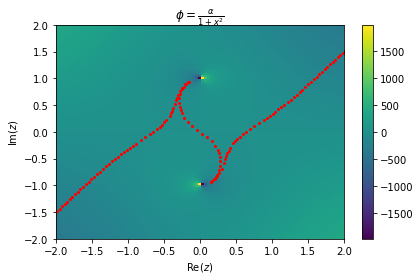

In [27]:
# Plot final contour and trajectory
N = 100
cont_space = 10
u, v = np.meshgrid(np.linspace(domain[0], domain[1], N), np.linspace(domain[0], domain[1], N), indexing='ij')
z = u + 1j*v

fig, ax = plt.subplots()
ax.set_xlabel("Re($z$)")
ax.set_ylabel("Im($z$)")
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
# Plot h
im = ax.pcolormesh(u, v, np.real(expfun(z, y, alpha, nu)))
ax.set_title('$\phi = \\frac{\\alpha}{1+x^2}$')
fig.colorbar(im, ax=ax)

# Plot progress towards Lefschetz thimble
# for k in np.linspace(0, pmod.trajectory.shape[0], pmod.trajectory.shape[0]//cont_space, endpoint=False):
#     k = int(k)
#     ax.scatter(pmod.trajectory[k].points.real[1:-1].flatten(), pmod.trajectory[k].points.imag[1:-1].flatten(), s=4, c='r')
ax.scatter(pmod.contour.points.real[1:-1].flatten(), pmod.contour.points.imag[1:-1].flatten(), s=4, c='r')
ax.set_rasterization_zorder(-10)
plt.tight_layout()
plt.show()
fig.savefig('/Users/DylanJow/Desktop/PL_rational.pdf', dpi=300, transparent=True)

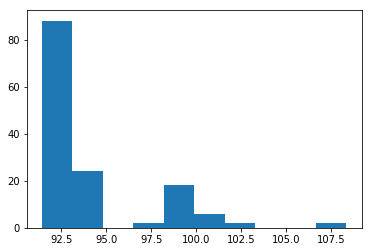

In [28]:
plt.figure()
plt.hist(pmod.expfun(pmod.contour.points.T, *pmod.expargs).flatten().imag)
plt.show()

In [29]:
def ims_loc(y, alpha):
    p = [1, -y, 2, -2*y, 1-alpha, -y]
    return np.roots(p)

ims = ims_loc(y, alpha)
real_ims = ims[np.where(np.abs(ims.imag)<1e-6)[0]].real

In [30]:
real_ims

array([-0.64359425,  0.64359425,  0.        ])

In [31]:
pmod.expfun(real_ims, *pmod.expargs).flatten().imag

array([ 91.42135624,  91.42135624, 100.        ])

In [41]:
hist = np.histogram(pmod.expfun(pmod.contour.points.T, *pmod.expargs).flatten().imag, bins='auto')
centres = ((hist[1] + np.roll(hist[1],1))/2)[1:]

In [42]:
hist

(array([64, 26, 16,  6,  0,  0,  0,  2,  8, 16,  0,  2,  0,  0,  0,  0,  0,
         0,  2]),
 array([ 91.42135163,  92.31363885,  93.20592607,  94.09821329,
         94.99050051,  95.88278773,  96.77507495,  97.66736217,
         98.55964939,  99.45193661, 100.34422383, 101.23651105,
        102.12879827, 103.02108549, 103.91337271, 104.80565993,
        105.69794715, 106.59023438, 107.4825216 , 108.37480882]))

In [43]:
centres

array([ 91.86749524,  92.75978246,  93.65206968,  94.5443569 ,
        95.43664412,  96.32893134,  97.22121856,  98.11350578,
        99.005793  ,  99.89808022, 100.79036744, 101.68265466,
       102.57494188, 103.4672291 , 104.35951632, 105.25180354,
       106.14409076, 107.03637799, 107.92866521])

In [44]:
from scipy.signal import find_peaks

In [50]:
peak_loc = find_peaks(np.pad(hist[0],1))[0]-1
peak = centres[peak_loc]

In [51]:
peak

array([ 91.86749524,  99.89808022, 101.68265466, 107.92866521])

In [52]:
peak_loc

array([ 0,  9, 11, 18])

In [53]:
imvals = pmod.expfun(pmod.contour.points.T, *pmod.expargs).flatten().imag

In [62]:
A = np.array([(imvals - p)**2 for p in peak])

In [64]:
B = np.argmin(A,axis=0)

In [78]:
stdev = np.sqrt(np.array([np.sum(A[i][np.where(B==i)[0]])/len(np.where(B==i)[0])**2 for i in np.arange(len(peak))]))

In [79]:
snr = peak/stdev

In [80]:
snr

array([ 984.60598057,  830.22659617, 7921.39959588,  342.11894687])

In [81]:
stdev

array([0.09330382, 0.12032628, 0.01283645, 0.31547117])

In [82]:
peak

array([ 91.86749524,  99.89808022, 101.68265466, 107.92866521])

In [83]:
hist

(array([64, 26, 16,  6,  0,  0,  0,  2,  8, 16,  0,  2,  0,  0,  0,  0,  0,
         0,  2]),
 array([ 91.42135163,  92.31363885,  93.20592607,  94.09821329,
         94.99050051,  95.88278773,  96.77507495,  97.66736217,
         98.55964939,  99.45193661, 100.34422383, 101.23651105,
        102.12879827, 103.02108549, 103.91337271, 104.80565993,
        105.69794715, 106.59023438, 107.4825216 , 108.37480882]))